In [57]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as spsp
import scipy.sparse.linalg as splinalg

N = 100
h = 1.0 / (N - 1)
X = np.linspace(0, 1, N)

def Kernel(i, j):
    return np.sin(X[i] + X[j]) / (1.0 + X[i] + X[j])

def RHS(i):
    return np.exp(10.0 * X[i]) * np.sin(10.0 * X[i])

############################################################
# Simple matvec for A
def mv_simple(u):
    k = len(u)
    v = np.zeros(k)
    
    for i in range(0, k):
        res = 0.0
        for j in range(0, k):
            res = res + (Kernel(i+1, j+1) * u[j]) * h
        
        if i == 0:
            v[i] = -(u[1] - 2*u[0]) / h**2  + res
        elif i == k-1:
            v[i] = -(u[k-2] - 2*u[k-1]) / h**2  + res 
        else:
            v[i] = -(u[i+1] - 2*u[i] + u[i-1]) / h**2 + res
            
    return v

############################################################
# Splitting: A = L + D + U
def mv_A(u):
    k = len(u)
    v = np.zeros(k)
    h2 = h**2
    
    for i in range(0, k):
        res = 0.0
        res += 0.5 * (Kernel(i+1, 1) * u[0]) * h 
        res += 0.5 * (Kernel(i+1, k) * u[k-1]) * h
        for j in range(0, k-1):
            res += 0.5 * (Kernel(i+1, j+1) * u[j]) * h
            res += 0.5 * (Kernel(i+1, j+2) * u[j+1]) * h
        
        if i == 0:
            v[i] += -(u[1]) / h2
            v[i] += -( -2*u[0] ) / h2
        elif i == k-1:
            v[i] += -(u[k-2]) / h2
            v[i] += -( -2*u[k-1] ) / h2
        else:
            v[i] += -(u[i+1]) / h2
            v[i] += -( -2*u[i]) / h2
            v[i] += -(u[i-1]) / h2
         
        v[i] += res
        
    return v
    
# Diagonal
def mv_D(u):
    k = len(u)
    v = np.zeros(k)
    h2 = h**2
    
    for i in range(0, k):
        res = 0.0
        if i == 0:
            res += 0.5 * (Kernel(i+1, 1) * u[0]) * h 
        if i == k-1:
            res += 0.5 * (Kernel(i+1, k) * u[k-1]) * h
        for j in range(0, k-1):
            if i == j:
                res += 0.5 * (Kernel(i+1, j+1) * u[j]) * h
            if i == j+1:
                res += 0.5 * (Kernel(i+1, j+2) * u[j+1]) * h
        
        if i == 0:
            v[i] += -( -2*u[0] ) / h2
        elif i == k-1:
            v[i] += -( -2*u[k-1] ) / h2
        else:
            v[i] += -( -2*u[i]) / h2
            
         
        v[i] += res
        
    return v

# Lower
def mv_L(u):
    k = len(u)
    v = np.zeros(k)
    h2 = h**2
    
    for i in range(0, k):
        res = 0.0
        if i > 0:
            res += 0.5 * (Kernel(i+1, 1) * u[0]) * h 
        
        for j in range(0, k-1):
            if i > j:
                res += 0.5 * (Kernel(i+1, j+1) * u[j]) * h
            if i > j+1:
                res += 0.5 * (Kernel(i+1, j+2) * u[j+1]) * h
        
        if i == 0:
            pass
        elif i == k-1:
            v[i] += -(u[k-2]) / h2
        else:
            v[i] += -(u[i-1]) / h2
         
        v[i] += res
        
    return v

# Upper
def mv_U(u):
    k = len(u)
    v = np.zeros(k)
    h2 = h**2
    
    for i in range(0, k):
        res = 0.0
        if i < k-1:
            res += 0.5 * (Kernel(i+1, k) * u[k-1]) * h
            
        for j in range(0, k-1):
            if i < j:
                res += 0.5 * (Kernel(i+1, j+1) * u[j]) * h
            if i < j+1:
                res += 0.5 * (Kernel(i+1, j+2) * u[j+1]) * h
        
        if i == 0:
            v[i] += -(u[1]) / h2
        elif i == k-1:
            pass
        else:
            v[i] += -(u[i+1]) / h2
            
        v[i] += res
        
    return v

# Mix, for testing
def mv_mix(u):
    return mv_L(u) + mv_D(u) + mv_U(u)

############################################################

b = [RHS(i) for i in range(1, N-1)]
A = splinalg.LinearOperator((N-2, N-2), matvec=mv_simple)

############################################################
# Report callback
iters, resnorm, report_list = 0, 0, []
def report(xk):
    global iters
    global resnorm
    global report_list
    iters += 1
    resnorm = np.linalg.norm(A*xk - b)
    #print("Iters = %d ; resnorm = %f" % (iters, resnorm))
    report_list.append((iters, resnorm))

In [58]:
# Testing
print("Testing of different matrix buildings")
print(" ")

A1 = splinalg.LinearOperator((N-2, N-2), matvec=mv_A)
print("A1 - base matvec")
A2 = splinalg.LinearOperator((N-2, N-2), matvec=mv_simple)
print("A2 - simple matvec")
A3 = splinalg.LinearOperator((N-2, N-2), matvec=mv_mix)
print("A3 - mix matvec, using splitting: A = L + D + U")

iters, resnorm, report_list = 0, 0, []
x1 = splinalg.cg(A1, b, callback=report)[0]
print("A1: ", report_list[-1])

iters, resnorm, report_list = 0, 0, []
x2 = splinalg.cg(A2, b, callback=report)[0]
print("A2: ", report_list[-1])
print("error x1 - x2: ", np.linalg.norm(x1 - x2))

iters, resnorm, report_list = 0, 0, []
x3 = splinalg.cg(A3, b, callback=report)[0]
print("A3: ", report_list[-1])
print("error x1 - x3: ", np.linalg.norm(x1 - x3))

Testing of different matrix buildings
 
A1 - base matvec
A2 - simple matvec
A3 - mix matvec, using splitting: A = L + D + U
A1:  (98, 4.214167449624732e-09)
A2:  (98, 4.15289045725255e-09)
error x1 - x2:  2.325107083135632e-13
A3:  (98, 4.3755018921166005e-09)
error x1 - x3:  2.4238233361184163e-13


In [59]:
# Full matrix form 
print("Dimension is ", N-2)
print(" ")

A_D = splinalg.LinearOperator((N-2, N-2), matvec=mv_D)
A_L = splinalg.LinearOperator((N-2, N-2), matvec=mv_L)
A_U = splinalg.LinearOperator((N-2, N-2), matvec=mv_U)

Afull = A.matmat(np.identity(N-2))
Dfull = A_D.matmat(np.identity(N-2))
Lfull = A_L.matmat(np.identity(N-2)) 
Ufull = A_U.matmat(np.identity(N-2))

print(Afull)
print(" ")
print(Dfull + Lfull + Ufull - Afull)
print(" ")
print("Cond number of A is ", np.linalg.cond(Afull))

Dimension is  98
 
[[ 1.96020002e+04 -9.80099970e+03  3.92165516e-04 ...  4.23665726e-03
   4.24350534e-03  4.24985346e-03]
 [-9.80099970e+03  1.96020004e+04 -9.80099951e+03 ...  4.24350534e-03
   4.24985346e-03  4.25570635e-03]
 [ 3.92165516e-04 -9.80099951e+03  1.96020006e+04 ...  4.24985346e-03
   4.25570635e-03  4.26106868e-03]
 ...
 [ 4.23665726e-03  4.24350534e-03  4.24985346e-03 ...  1.96020032e+04
  -9.80099682e+03  3.15824150e-03]
 [ 4.24350534e-03  4.24985346e-03  4.25570635e-03 ... -9.80099682e+03
   1.96020032e+04 -9.80099687e+03]
 [ 4.24985346e-03  4.25570635e-03  4.26106868e-03 ...  3.15824150e-03
  -9.80099687e+03  1.96020031e+04]]
 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 
Cond number of A is  3846.051219089365


In [65]:
# Jacobi (or diagonal) preconditioner

Jacobi = lambda x: splinalg.spsolve(Dfull, x)
M_Jacobi = splinalg.LinearOperator((N-2, N-2), matvec=Jacobi)

iters, resnorm, report_list = 0, 0, []
x = splinalg.cg(Afull, b, callback=report)
print("Without precond: ", report_list[-1])
report_list_default = report_list

iters, resnorm, report_list = 0, 0, []
x = splinalg.cg(Afull, b, M=M_Jacobi, callback=report)
print("With precond: ", report_list[-1])
report_list_Jacobi = report_list

Without precond:  (98, 3.477521416452077e-09)
With precond:  (98, 3.39726462145296e-09)


In [66]:
# Symmetric Gauss-Seidel (SGS)
SGS_matrix = np.matmul(np.matmul(Dfull + Lfull, np.linalg.inv(Dfull)), Dfull + Ufull)
SGS = lambda x: splinalg.spsolve(SGS_matrix, x)
M_SGS = splinalg.LinearOperator((N-2, N-2), matvec=SGS)

iters, resnorm, report_list = 0, 0, []
x = splinalg.cg(Afull, b, callback=report)
print("Without precond: ", report_list[-1])

iters, resnorm, report_list = 0, 0, []
x = splinalg.cg(Afull, b, M=M_SGS, callback=report)
print("With precond: ", report_list[-1])
report_list_SGS = report_list

Without precond:  (98, 3.477521416452077e-09)
With precond:  (40, 0.1725521475624313)


In [67]:
# Laplace precond
############################################################
# Simple matvec for A
def mv_laplace(u):
    k = len(u)
    v = np.zeros(k)
    
    for i in range(0, k):
        if i == 0:
            v[i] = (u[1] - 2*u[0]) / h**2
        elif i == k-1:
            v[i] = (u[k-2] - 2*u[k-1]) / h**2
        else:
            v[i] = (u[i+1] - 2*u[i] + u[i-1]) / h**2
            
    return v

Laplace = splinalg.LinearOperator((N-2, N-2), matvec=mv_laplace)
Laplacefull = Laplace.matmat(np.identity(N-2))

LaplacePrecond = lambda x: splinalg.spsolve(Laplacefull, x)
M_LaplacePrecond = splinalg.LinearOperator((N-2, N-2), matvec=LaplacePrecond)

iters, resnorm, report_list = 0, 0, []
x = splinalg.cg(Afull, b, callback=report)
print("Without precond: ", report_list[-1])

iters, resnorm, report_list = 0, 0, []
x = splinalg.cg(Afull, b, M=M_LaplacePrecond, callback=report)
print("With precond: ", report_list[-1])
report_list_Laplace = report_list

Without precond:  (98, 3.477521416452077e-09)
With precond:  (3, 1.6791783475997714e-06)


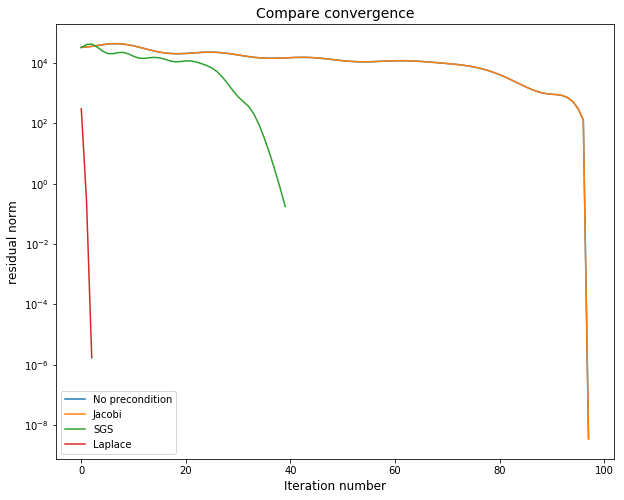

In [76]:
plt.figure(figsize=(10, 8))
plt.plot(list(map(lambda x: x[1], report_list_default)), label="No precondition")
plt.plot(list(map(lambda x: x[1], report_list_Jacobi)), label="Jacobi")
plt.plot(list(map(lambda x: x[1], report_list_SGS)), label="SGS")
plt.plot(list(map(lambda x: x[1], report_list_Laplace)), label="Laplace")
plt.title("Compare convergence", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.yscale('log')
plt.ylabel("residual norm", fontsize=12)
plt.legend()